In [5]:
import sleap
from sleap.io.visuals import save_labeled_video

# Load your labels and video
labels = sleap.Labels.load_file('/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/predictions/labels.v001.slp.240605_112728.predictions.slp')
video = labels.videos[0]  

In [2]:
labels.model

AttributeError: 'Labels' object has no attribute 'model'

In [6]:
frames = list(range(video.num_frames))  # All frames
filename = "fatiguesleap_RhodesInterleaved.mp4"
fps = 30
scale = 1.0

# Save annotated video
save_labeled_video(
    filename=filename,
    labels=labels,
    video=video,
    frames=frames,
    fps=fps,
    scale=scale,
    show_edges=True,
    marker_size=4
)

Writing video with 22972 frame images...
INFO:sleap.io.visuals:Chunks: 359, chunk size: 64
Finished 64 frames in 2.2 s, fps = 29, approx 778.4 s remaining
Finished 128 frames in 3.2 s, fps = 40, approx 570.7 s remaining
Finished 192 frames in 4.2 s, fps = 46, approx 498.4 s remaining
Finished 256 frames in 5.3 s, fps = 48, approx 472.7 s remaining
Finished 320 frames in 6.4 s, fps = 50, approx 454.8 s remaining
Finished 384 frames in 7.5 s, fps = 51, approx 441.4 s remaining
Finished 448 frames in 8.7 s, fps = 52, approx 435.2 s remaining
Finished 512 frames in 9.9 s, fps = 52, approx 436.0 s remaining
Finished 576 frames in 10.9 s, fps = 53, approx 425.5 s remaining
Finished 640 frames in 12.1 s, fps = 53, approx 421.9 s remaining
Finished 704 frames in 13.2 s, fps = 53, approx 418.9 s remaining
Finished 768 frames in 14.3 s, fps = 54, approx 412.7 s remaining
Finished 832 frames in 15.1 s, fps = 55, approx 402.6 s remaining
Finished 896 frames in 16.0 s, fps = 56, approx 393.6 s rema

In [7]:
import h5py
import numpy as np

filename = "/home/jakejoseph/Desktop/Joseph_Code/SLEAPV1/labels.v001.009_trim10.analysis.h5"

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
/home/jakejoseph/Desktop/Joseph_Code/SLEAPV1/labels.v001.009_trim10.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(2054, 5, 2, 1)

===nodes===
0: DIP
1: PIP
2: MCP
3: Wrist
4: Forearm



In [9]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [10]:
locations = fill_missing(locations)

In [11]:
wrist_loc = locations[:, 3, :, :]
forearm_loc = locations[:, 4, :, :]
mcp_loc = locations[:, 2, :, :]

In [26]:
predictor = sleap.load_model('/home/jakejoseph/Desktop/Joseph_Code/SLEAPV1/models/240510_125016.single_instance.n=151')
video = sleap.load_video("/home/jakejoseph/Desktop/Joseph_Code/trimmed_videos/trim10.mp4")

In [21]:
from time import perf_counter
import numpy as np


class SimulatedCamera:
    """Simulated camera class that serves frames from memory continuously.

    Attributes:
        frames: Numpy array with pre-loaded frames.
        frame_counter: Count of frames that have been grabbed.
    """

    frames: np.ndarray
    frame_counter: int

    def __init__(self, frames):
        self.frames = frames
        self.frame_counter = 0
    
    def grab_frame(self):
        idx = self.frame_counter % len(self.frames)
        self.frame_counter += 1
        return self.frames[idx]

In [34]:
recording_duration = 300  # session length in frames

# Pre-load images onto "camera"
camera = SimulatedCamera(video[:1000])

# Camera capture loop
inference_times = []
frames_recorded = 0
while frames_recorded < recording_duration:
    # Get the next frame.
    frame = camera.grab_frame()
    frames_recorded += 1

    # Get inference results for the frame and time how long it took.
    t0 = perf_counter()
    frame_predictions = predictor.inference_model.predict_on_batch(np.expand_dims(frame, axis=0))
    dt = perf_counter() - t0
    inference_times.append(dt)

# Convert to milliseconds.
inference_times = np.array(inference_times) * 1000

# Separate out first timing from the rest. The first inference call is much slower as it builds the compute graph.
first_inference_time, inference_times = inference_times[0], inference_times[1:]
print(f"First inference time: {first_inference_time:.1f} ms")
print(f"Inference times: {inference_times.mean():.1f} +- {inference_times.std():.1f} ms")

First inference time: 50.8 ms
Inference times: 31.2 +- 1.8 ms


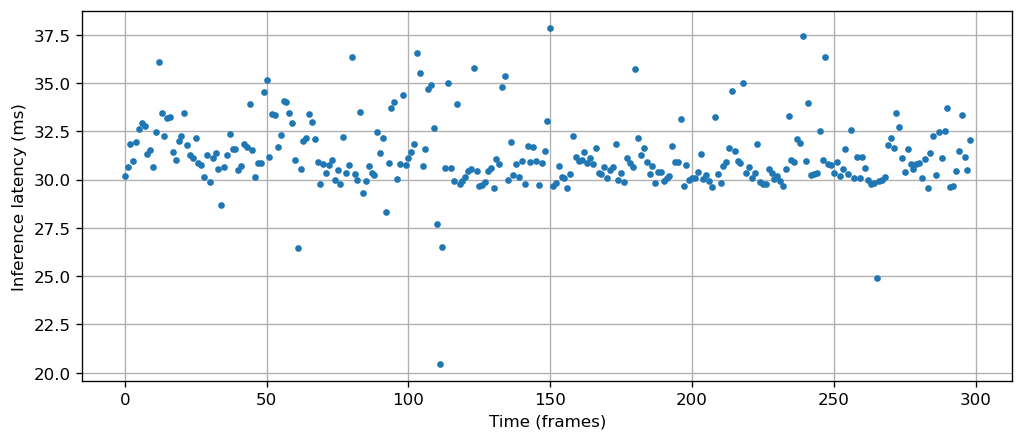

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4), dpi=120, facecolor="w")
plt.plot(inference_times, ".")
plt.xlabel("Time (frames)")
plt.ylabel("Inference latency (ms)")
plt.grid(True);

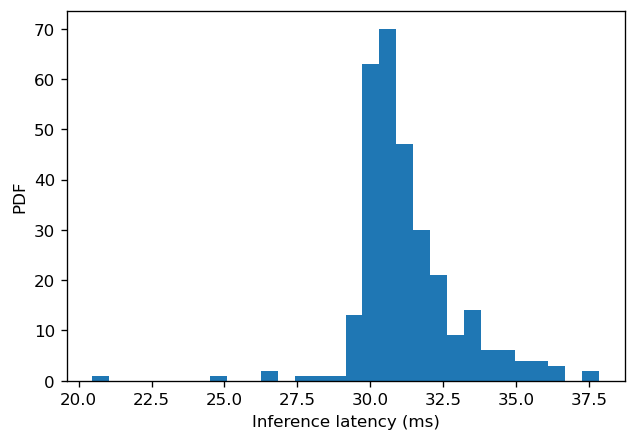

In [36]:
plt.figure(figsize=(6, 4), dpi=120, facecolor="w")
plt.hist(inference_times, bins=30)
plt.xlabel("Inference latency (ms)")
plt.ylabel("PDF");